In [1]:
# Standard Python packages
import os
from pathlib import Path

# Test if this is a colab environment
iscolab = 'COLAB_RELEASE_TAG' in os.environ

# Install LAMMPS and atomman in colab if needed
if iscolab and not Path('lmp').exists():
    
    if not Path('run').exists():
        Path('run').mkdir()
    
    print('Installing LAMMPS - please wait...')
    !wget https://github.com/lmhale99/atomman-demo/raw/main/lmp.gz
    !gunzip lmp.gz
    !chmod 755 lmp
    
    print('Installing atomman')
    !pip install atomman py3Dmol

    print('!!!!! RESTART KERNEL/RUNTIME BEFORE CONTINUING!!!!!')
    
# Import installed packages
else:
    import atomman as am
    import atomman.unitconvert as uc
    print(f'atomman version {am.__version__} loaded')
    import matplotlib.pyplot as plt

atomman version 1.4.10 loaded


## Define LAMMPS script

With some terms pulled out to be Python-controlled variables

In [2]:
template = """
# 2d LJ liquid with thermostat

# ---------------
# model variables
# ---------------

variable        rho index <rho>
variable        temp index <temp>
variable        cutoff index <cutoff>
variable        srate equal <srate>

# ---------------
# settings
# ---------------

units		lj
dimension       2
atom_style	atomic
boundary        p p p
neighbor	0.3 bin
neigh_modify	every 20 delay 0 check no

# ---------------
# create simulation box and atoms
# ---------------

lattice		sq2 ${rho}
region		box block 0 20 0 20 -0.25 0.25
#region		box prism 0 20 0 20 -0.25 0.25 0 0 0
create_box	1 box
create_atoms	1 box

mass		1 1.0

# ---------------
# LJ potential
# ---------------

pair_style	lj/cut ${cutoff}
pair_coeff	1 1 1.0 1.0

# ---------------
# initial velocities
# ---------------

velocity	all create ${temp} 87287 loop geom

# ---------------
# fixes for time integration and thermostatting
# ---------------

fix             1 all nve
fix             2 all langevin ${temp} ${temp} 1.0 77478 zero yes

fix		3 all enforce2d

# ---------------
# material properties
# ---------------

compute         myRDF all rdf 50
fix             10 all ave/time 10 2500 25000 c_myRDF[*] &
                file data.rdf mode vector

compute         msd all msd
variable        dcoeff equal c_msd[4]/(step*dt+0.001)/4
thermo_style    custom step temp epair press c_msd[4] v_dcoeff

fix             11 all vector 1000 c_msd[4]
variable        dfit equal slope(f_11)/(1000*dt)/4
thermo_style    custom step temp epair press c_msd[4] v_dcoeff v_dfit
thermo_style    custom step temp epair press c_msd[4] v_dcoeff v_dfit

compute         cnum all coord/atom cutoff 1.5

# ---------------
# output
# ---------------

thermo		1000

dump		1 all custom 500 *.dump id type x y z c_cnum

# ---------------
# run
# ---------------

run             <runsteps>
"""

Fill in Python-controlled variables.  This makes it easy to change or loop over these inputs.

In [3]:
lammps_variables = {}
lammps_variables['rho'] = 0.7
lammps_variables['temp'] = 0.5
lammps_variables['cutoff'] = 2.5
lammps_variables['srate'] = 2.5
lammps_variables['runsteps'] = 50000

script = am.tools.filltemplate(template, lammps_variables, '<', '>')

## Run LAMMPS and look at thermo data

In [4]:
log = am.lammps.run('lmp', script=script)

In [5]:
thermo = log.simulations[0].thermo
thermo

,Step,Temp,E_pair,Press,c_msd[4],v_dcoeff,v_dfit
0,0,0.500000,-2.173747,-2.207438,0.000000,0.000000,5.000000e+18
1,1000,0.529999,-2.081195,0.387807,0.852391,0.042611,4.261956e-02
2,2000,0.504990,-2.087844,0.104136,1.603126,0.040074,4.007815e-02
3,3000,0.497979,-2.072382,0.287898,2.313126,0.038550,3.845057e-02
4,4000,0.512601,-2.095322,0.161853,3.259154,0.040737,3.989521e-02
5,5000,0.522829,-2.124188,0.182372,4.371598,0.043714,4.255468e-02
6,6000,0.505596,-2.103188,0.176094,5.155953,0.042965,4.314697e-02
7,7000,0.472484,-2.105480,0.143482,5.899774,0.042140,4.289742e-02
8,8000,0.515205,-2.115480,0.268630,6.634803,0.041466,4.237124e-02
9,9000,0.511926,-2.097016,0.200149,7.612893,0.042293,4.245972e-02


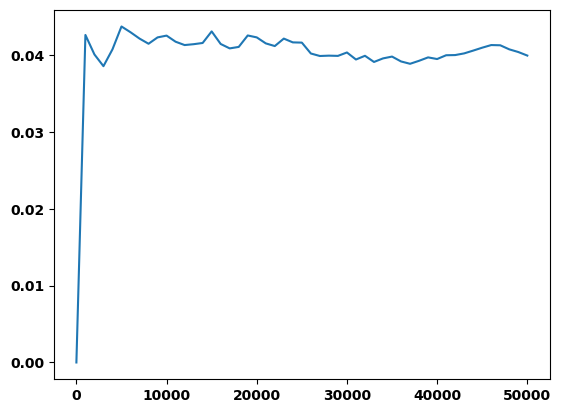

In [6]:
plt.plot(thermo.Step, thermo.v_dcoeff)

It is very easy to parse values, compute means, etc.

In [7]:
thermo.v_dcoeff[thermo.Step > 5000].mean()

0.0408113332

## Look at RDF data

Atomman has a built-in class for looking at RDF data

In [8]:
rdf = am.thermo.RDF(lammps_rdf_file='data.rdf')

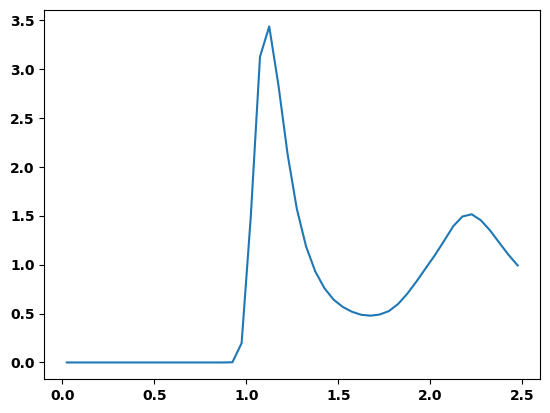

In [9]:
plt.plot(rdf.r, rdf.g)

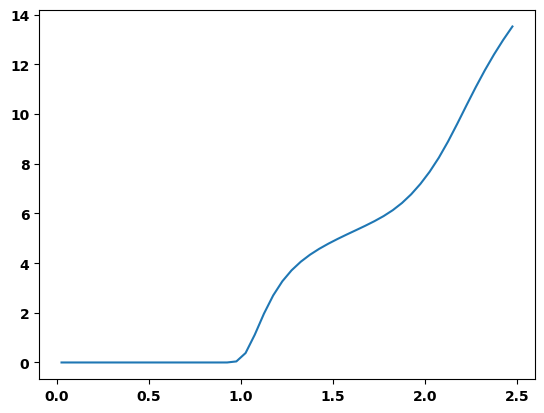

In [10]:
plt.plot(rdf.r, rdf.coord)

In addition to simply averaging the g(r) and coord(r) values, the RDF class contains additional methods for transforming to other representations.

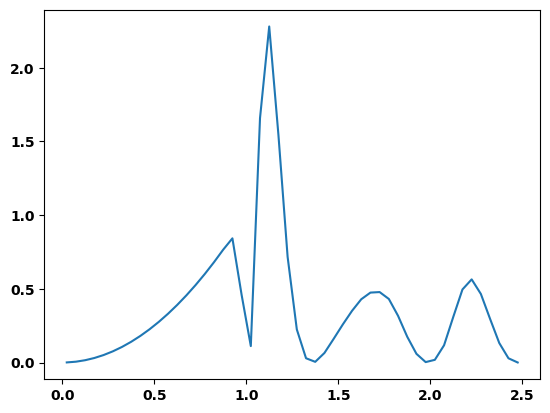

In [11]:
plt.plot(rdf.r, rdf.I)

## Load dump file(s) and look at properties

In [12]:
final_dump = f'{thermo.Step[-1]}.dump'

system = am.load('atom_dump', final_dump)
print(system.atoms_prop())

['atype', 'pos', 'atom_id', 'c_cnum']


In [13]:
am.plot.py3Dmol.view_3d(system, atomsize=0.8, prop_name='c_cnum')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
for fglob in ['*.dump', 'data.rdf', 'log.lammps']:
    for fname in Path.cwd().glob(fglob):
        fname.unlink()